In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/

drive  ECG_DATA  sample_data


In [ ]:
!ls /content/ECG_DATA/train

'ECG Images of Myocardial Infarction Patients (240x12=2880)'
'ECG Images of Patient that have abnormal heartbeat (233x12=2796)'
'ECG Images of Patient that have History of MI (172x12=2064)'
'Normal Person ECG Images (284x12=3408)'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN architecture
class ECG_Classifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ECG_Classifier, self).__init__()

        # Convolutional Block 1
        # Input image size: [BATCH_SIZE, 3, 150, 150]
        # (Batch size, Channels, Height, Width)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output size after this block: [BATCH_SIZE, 16, 75, 75]

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output size after this block: [BATCH_SIZE, 32, 37, 37]

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Output size after this block: [BATCH_SIZE, 64, 18, 18]

        # Fully Connected (Dense) Layers
        # We need to flatten the output of the last conv layer
        self.fc1 = nn.Linear(64 * 18 * 18, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes) # num_classes should be 4

    def forward(self, x):
        # Apply the convolutional blocks
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten the feature maps for the fully connected layers
        # The size of the tensor after the last pool layer is (batch_size, 64, 18, 18)
        # We need to flatten it to (batch_size, 64 * 18 * 18)
        x = x.view(-1, 64 * 18 * 18)

        # Apply the fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Instantiate the model
num_classes = 4  # You have four classes in your dataset
model = ECG_Classifier(num_classes=num_classes)

# Optional: Print the model architecture to see all the layers
print(model)

# Check if a GPU is available and move the model to it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"\nModel has been instantiated and moved to {device}.")

ECG_Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20736, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

Model has been instantiated and moved to cuda.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
zip_file_path = '/content/drive/MyDrive/archive (1).zip'
unzip_path = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

print("Extraction complete.")

Extraction complete.


In [ ]:
!ls /content/ECG_DATA/train

'ECG Images of Myocardial Infarction Patients (240x12=2880)'
'ECG Images of Patient that have abnormal heartbeat (233x12=2796)'
'ECG Images of Patient that have History of MI (172x12=2064)'
'Normal Person ECG Images (284x12=3408)'


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- 1. Load the Data ---

data_root_dir = '/content/ECG_DATA'
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
BATCH_SIZE = 32

data_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(
    root=f'{data_root_dir}/train',
    transform=data_transform
)

test_dataset = datasets.ImageFolder(
    root=f'{data_root_dir}/test',
    transform=data_transform
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Data loaders created successfully.")

# --- 2. Define the Model, Loss Function, and Optimizer ---

class ECG_Classifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ECG_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 18 * 18, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ECG_Classifier(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- 3. The Training Loop ---

num_epochs = 10

print("\nStarting the training process...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

print("\nTraining complete.")

torch.save(model.state_dict(), 'ecg_classifier_model.pth')
print("Model saved to 'ecg_classifier_model.pth'.")

Data loaders created successfully.

Starting the training process...
Epoch [1/10], Loss: 2.5630
Epoch [2/10], Loss: 0.3296
Epoch [3/10], Loss: 0.1174
Epoch [4/10], Loss: 0.0885
Epoch [5/10], Loss: 0.0377
Epoch [6/10], Loss: 0.0266
Epoch [7/10], Loss: 0.0205
Epoch [8/10], Loss: 0.0104
Epoch [9/10], Loss: 0.0185
Epoch [10/10], Loss: 0.0134

Training complete.
Model saved to 'ecg_classifier_model.pth'.


Test data loaders created successfully.
Model weights loaded and set to evaluation mode.

Accuracy on the test set: 0.9925

Classification Report:
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       1.00      1.00      1.00       239
     ECG Images of Patient that have History of MI (172x12=2064)       0.99      1.00      0.99       172
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       1.00      0.97      0.98       233
                          Normal Person ECG Images (284x12=3408)       0.98      1.00      0.99       284

                                                        accuracy                           0.99       928
                                                       macro avg       0.99      0.99      0.99       928
                                                    weighted avg       0.99      0.99      0.99       928



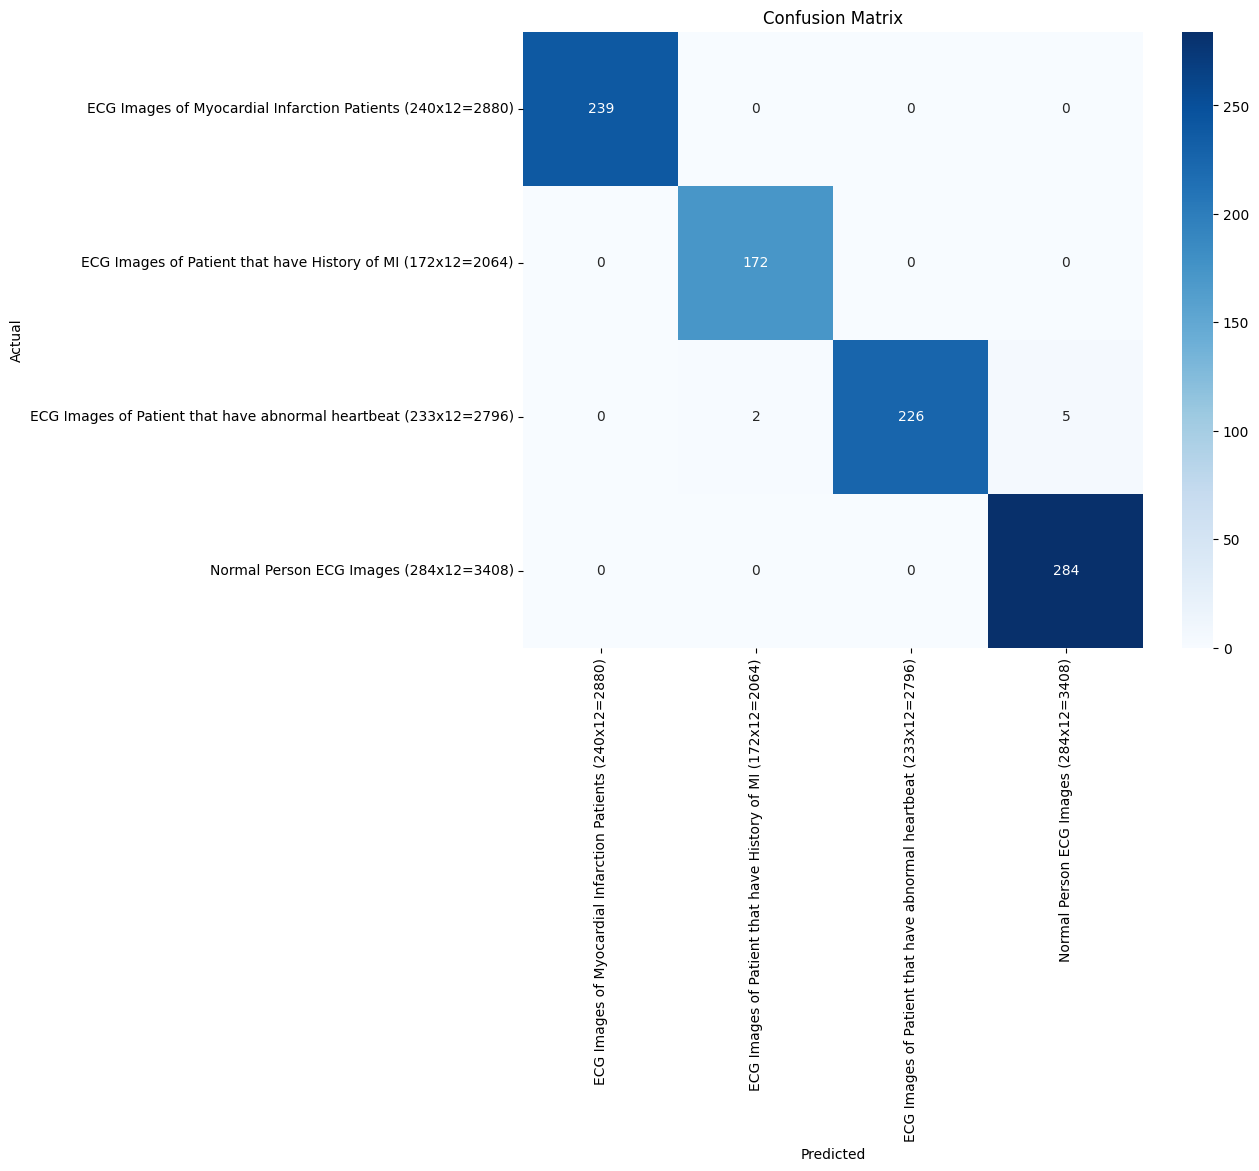

Evaluation complete.


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- 1. Load the Data Loaders (re-run this part if your runtime was reset) ---
data_root_dir = '/content/ECG_DATA'
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
BATCH_SIZE = 32

data_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
])

test_dataset = datasets.ImageFolder(
    root=f'{data_root_dir}/test',
    transform=data_transform
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Get the class names for the labels
class_names = test_dataset.classes
print("Test data loaders created successfully.")

# --- 2. Load the Trained Model ---

# We need the model architecture to load the saved state dictionary
class ECG_Classifier(nn.Module):
    # (Copy the ECG_Classifier class definition from the previous response here)
    def __init__(self, num_classes=4):
        super(ECG_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 18 * 18, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model and load the saved weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ECG_Classifier(num_classes=4).to(device)

# The model file 'ecg_classifier_model.pth' was saved in the previous step
model.load_state_dict(torch.load('ecg_classifier_model.pth'))
model.eval()  # Set the model to evaluation mode

print("Model weights loaded and set to evaluation mode.")

# --- 3. Evaluate the Model on the Test Dataset ---

all_labels = []
all_preds = []

with torch.no_grad():  # We don't need to compute gradients for evaluation
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# --- 4. Print the Evaluation Metrics ---

# Calculate and print overall accuracy
accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f'\nAccuracy on the test set: {accuracy:.4f}')

# Generate and print the classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Generate and plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Evaluation complete.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

# --- 1. Define the Model and Load its Weights ---

# The model architecture needs to be defined again to load the weights
class ECG_Classifier(nn.Module):
    def __init__(self, num_classes=4):
        super(ECG_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 18 * 18, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ECG_Classifier(num_classes=4).to(device)

# Load the saved model weights
model_path = 'ecg_classifier_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # Set the model to evaluation mode

print("Model loaded and ready for inference.")

# Get the class names
class_names = ['ECG Images of Myocardial Infarction Patients (240x12=2880)',
               'ECG Images of Patient that have History of MI (172x12=2064)',
               'ECG Images of Patient that have abnormal heartbeat (233x12=2796)',
               'Normal Person ECG Images (284x12=3408)']

# --- 2. Define the Prediction Function ---

def predict_single_image(image_path):
    """
    Predicts the class of a single ECG image from its file path.
    """
    inference_transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ])

    try:
        image = Image.open(image_path).convert('RGB')
        image_tensor = inference_transform(image)
        image_tensor = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image_tensor)

        _, predicted_idx = torch.max(outputs.data, 1)

        return class_names[predicted_idx.item()]

    except Exception as e:
        return f"Error: {e}"

# --- 3. Example Usage with your specific image ---

# Assuming your image is directly in the root of your Google Drive and has a .jpg extension.
# If it's in a subfolder or has a different extension, you must change this path.
test_image_path = '/content/drive/MyDrive/ECG-example-Normal-ECG-with-sinus-rhythm-5.png'

prediction = predict_single_image(test_image_path)
print(f"\nThe model predicts that the ECG image belongs to the category: {prediction}")

Model loaded and ready for inference.

The model predicts that the ECG image belongs to the category: ECG Images of Myocardial Infarction Patients (240x12=2880)
